# Vision Transformer (ViT) Explained

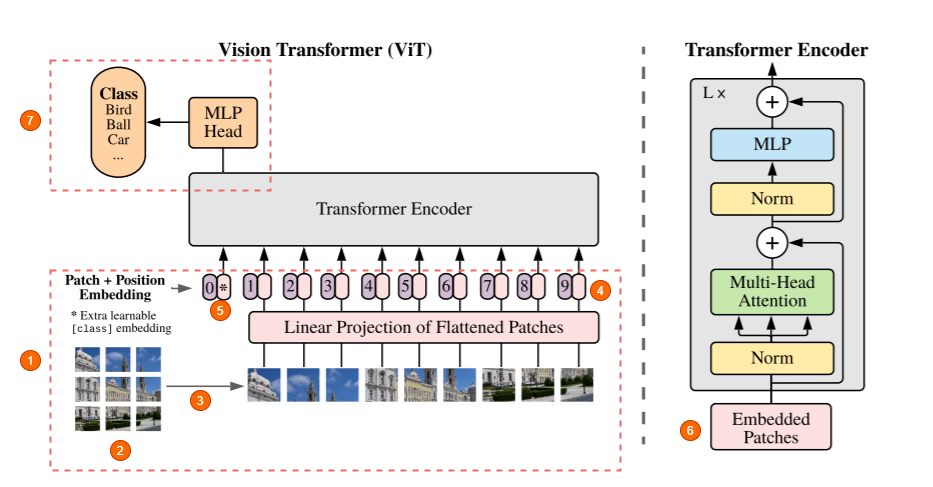

(1) The ViT Architecture is based on Transformer architecture which was originally proposed to text tasks as NLP. ViT uses only the Encoder part of the transformer to feed images into the network.

(2) The images are breaking down into fixed size patches, for example 16x16 or 32x32. More patches means more simpler it is to train the networks as the patches themselves get smaller.

(3) The patches are then unrolled (flattened) and sent for further processing into the network.

(4) Unlike NNs the model has no idea about the position of the samples in the sequence, so each sample is a patch from the input image. The image is fed along with a positional embedding vector and into the encoder, letting the model to learn about the image structure.

(5) There is also a special token at the start of the embedding vector.

(6) Each image patch is first unrolled (flattened) into a big vector and gets multiplied with an embedding matrix which is also learnable, creating embedded patches. The embedded patches are combined with the positional embedding vector and that gets fed into the Tranformer.

(7) With the only difference being, instead of a decoder the output from the encoder is passed directly into a Feed Forward Neural Network to obtain the classification output.


# Imports

In [1]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 9.8 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import model_from_json
import tensorflow_addons as tfa

# Download dataset

Mount Google drive and unzip the kgalagadi dataset to local folder. Keep the folder structure as original file.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!mkdir '/content/dataset'

In [5]:
!unzip '/content/drive/MyDrive/datasets/lila.bc/KGA_S1.lila.zip' -d '/content/dataset'

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0121.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0122.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0123.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0124.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0125.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0126.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0127.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0128.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0129.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0130.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0131.JPG  
 extracting: /content/dataset/KGA_S1/B05/B05_R1/KGA_S1_B05_R1_IMAG0132.JPG  
 extracting: /con

# Hyperparameters Setup

Defining some variables and model hyperparameters used by the experiment. All variables are in UPPER CASE to be facilitates the code understanding.

In [84]:
NUM_CLASSES = 31
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 256 # default 256
NUM_EPOCHS = 20 # change to 100
IMAGE_SIZE = 72  # We'll resize input images to this size
PATCH_SIZE = 6  # Size of the patches to be extract from the input images
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Size of the transformer layers
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]  # Size of the dense layers of the final classifier
CLASSES = [
  'aardvarkantbear', 'birdofprey', 'birdother', 'blank', 'bustardkori', 'caracal', 'catafricanwild', 'cheetah', \
  'duikercommongrey', 'eland', 'foxbateared', 'foxcape', 'gemsbokoryx', 'harecape', 'hartebeestred', 'honeybadger', \
  'human', 'hyenabrown', 'hyenaspotted', 'jackalblackbacked', 'kudu', 'leopard', 'lionfemale', 'meerkatsuricate', \
  'ostrich', 'porcupine', 'reptilesamphibians', 'rodent', 'secretarybird', 'steenbok', 'wildebeestblue'
]

# Dataset Setup

Copy kgalagadi CSV files to create a dataframe from all files. Remove nonexistent files to avoid warning and errors during the training process. Create train(88%), validation(10%) and test (2%) datasets to be used in the model. 

## Create dataframes

In [7]:
!cp /content/drive/MyDrive/datasets/lila.bc/KGA_S1_report*.* -d /content/dataset

In [8]:
lila_repo = pd.read_csv('/content/dataset/KGA_S1_report_lila.csv', sep=',')
lila_inve = pd.read_csv('/content/dataset/KGA_S1_report_lila_image_inventory.csv', sep=',')

dataset = pd.merge(lila_repo, lila_inve, how="left", on="capture_id")
dataset = dataset.rename(columns={'question__species': 'label'})
dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='question__')))]
dataset.image_path_rel = '/content/dataset/' + dataset.image_path_rel
image_path_rel = dataset.pop('image_path_rel')
dataset.insert(1, 'image_path_rel', image_path_rel)

dataset.head()

,capture_id,image_path_rel,season,site,roll,capture,capture_date_local,capture_time_local,subject_id,label,p_users_identified_this_species,pielous_evenness_index,image_rank_in_capture
0,KGA_S1#A01#1#1,/content/dataset/KGA_S1/A01/A01_R1/KGA_S1_A01_...,KGA_S1,A01,1,1,2018-10-27,07:50:14,33326947,human,1.0,0.0,1
1,KGA_S1#A01#1#1,/content/dataset/KGA_S1/A01/A01_R1/KGA_S1_A01_...,KGA_S1,A01,1,1,2018-10-27,07:50:14,33326947,human,1.0,0.0,2
2,KGA_S1#A01#1#1,/content/dataset/KGA_S1/A01/A01_R1/KGA_S1_A01_...,KGA_S1,A01,1,1,2018-10-27,07:50:14,33326947,human,1.0,0.0,3
3,KGA_S1#A01#1#2,/content/dataset/KGA_S1/A01/A01_R1/KGA_S1_A01_...,KGA_S1,A01,1,2,2018-10-27,07:51:15,33326948,human,1.0,0.0,1
4,KGA_S1#A01#1#2,/content/dataset/KGA_S1/A01/A01_R1/KGA_S1_A01_...,KGA_S1,A01,1,2,2018-10-27,07:51:15,33326948,human,1.0,0.0,2


## Remove nonexistent files

In [9]:
# remove files that does not exist
is_f = []
for p in dataset.image_path_rel.values:
    if os.path.isfile(p):
        is_f.append(1)
    else:
        is_f.append(0)
dataset['is_f'] = is_f
dataset = dataset.loc[dataset.is_f == 1]
dataset.shape

(10267, 14)

## Data Augmentation

In [106]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Create datasets

In [107]:
# split the dataframe into train and test dataframes
train_df, test_df = train_test_split(dataset, test_size = 0.05, random_state = 42)

In [112]:
DF_DATASET = '/content/dataset'

# images generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.1,
                                                          #  preprocessing_function = data_augment
                                                           )

# load training and validating images from directory
train_set = data_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'image_path_rel',
                                         y_col = 'label',
                                         classes = CLASSES,
                                         subset = 'training',
                                         seed = 574,
                                         color_mode = 'rgb',
                                         shuffle = True,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical',
                                         validate_filenames = False)

valid_set = data_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'image_path_rel',
                                         y_col = 'label',
                                         classes = CLASSES,
                                         subset = 'validation',
                                         seed = 32,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical',
                                         validate_filenames = False)

test_set  = data_gen.flow_from_dataframe(dataframe = test_df,
                                         x_col = 'image_path_rel',
                                         y_col = 'label',
                                         classes = CLASSES,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         seed = 986,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical',
                                         validate_filenames = False)

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 8778 non-validated image filenames belonging to 31 classes.
Found 975 non-validated image filenames belonging to 31 classes.
Found 514 non-validated image filenames belonging to 31 classes.


## Show image samples

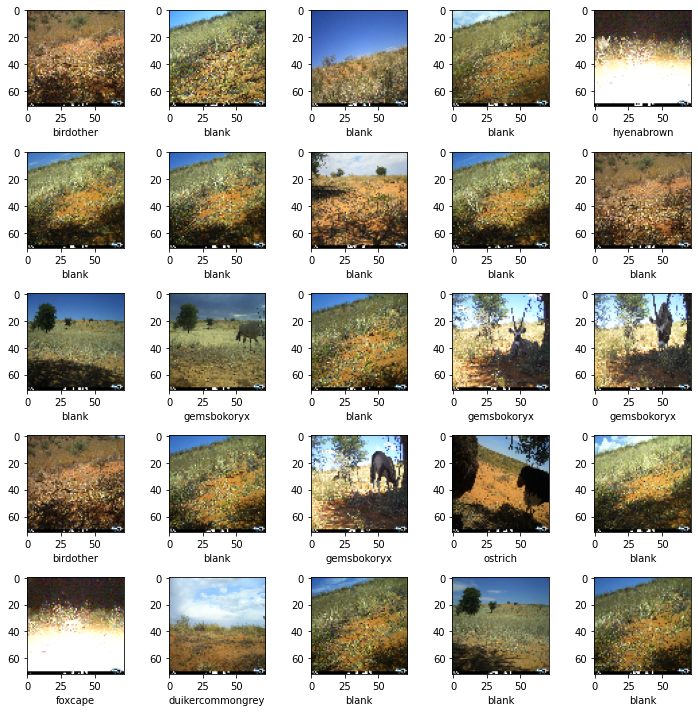

In [113]:
# show image samples
images, labels = next(test_set)[:25]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img)
    idx = np.where(label == 1)[0]
    ax.set_xlabel(list(train_set.class_indices)[idx.item()])
plt.tight_layout()
plt.show()

# Build ViT Model

Building a ViT model as described in ViT architecture. Defining input shape from the model. Adding data augmentation into before break down the images into fixed size patches. Adding a start token and unroll the patches. Adding L Transformer Block layers to the model. Feeding the vector into a final MLP layer.


## Patches Image Creator


In [114]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Display a Image Sample Patch

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


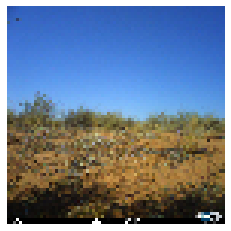

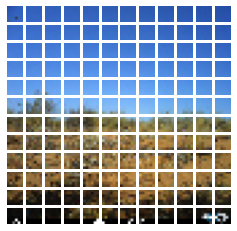

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

images = next(train_set)[0][:1]
image = images[0]

plt.imshow(image, vmin=0, vmax=255)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

patches = Patches(PATCH_SIZE)(resized_image)
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## MLP

In [116]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch Encoder Layer

In [117]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Create ViT Model

In [119]:
def create_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    # (2) Create patches.
    patches = Patches(PATCH_SIZE)(inputs)
    # (3, 4) Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # (6) Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units = TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units = MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits, name="vit_model")

    return model

In [120]:
# create classifier
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "vit_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 patches_11 (Patches)           (None, None, 108)    0           ['input_7[0][0]']                
                                                                                                  
 patch_encoder_6 (PatchEncoder)  (None, 144, 64)     16192       ['patches_11[0][0]']             
                                                                                                  
 layer_normalization_102 (Layer  (None, 144, 64)     128         ['patch_encoder_6[0][0]']        
 Normalization)                                                                           

# Run Experiment

Run experiment by compiling the model with the AdamW optimizer, Categorical Crossentropy loss and specific metrics (accuracy and top-5 accuracy). Train the model with pre-defined epochs and batch sizes. Evaluate and predict the model with some test images.

## Compile and Train Model

In [121]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    model.fit(x = train_set,
              batch_size = BATCH_SIZE,
              epochs = NUM_EPOCHS,
              validation_data = valid_set,
              callbacks = checkpoint_callback
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x = train_set)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model

In [122]:
model = run_experiment(vit_classifier)

Epoch 1/20
35/35 [==============================] - 670s 19s/step - loss: 3.0165 - accuracy: 0.6727 - top-5-accuracy: 0.9076 - val_loss: 1.1768 - val_accuracy: 0.7826 - val_top-5-accuracy: 0.9559
Epoch 2/20
35/35 [==============================] - 642s 18s/step - loss: 1.0299 - accuracy: 0.7568 - top-5-accuracy: 0.9543 - val_loss: 1.0446 - val_accuracy: 0.7826 - val_top-5-accuracy: 0.9559
Epoch 3/20
35/35 [==============================] - 646s 19s/step - loss: 0.9576 - accuracy: 0.7666 - top-5-accuracy: 0.9551 - val_loss: 0.8406 - val_accuracy: 0.7918 - val_top-5-accuracy: 0.9682
Epoch 4/20
35/35 [==============================] - 637s 18s/step - loss: 0.8397 - accuracy: 0.7845 - top-5-accuracy: 0.9592 - val_loss: 0.7239 - val_accuracy: 0.8246 - val_top-5-accuracy: 0.9662
Epoch 5/20
35/35 [==============================] - 634s 18s/step - loss: 0.7178 - accuracy: 0.8246 - top-5-accuracy: 0.9591 - val_loss: 0.7002 - val_accuracy: 0.8451 - val_top-5-accuracy: 0.9682
Epoch 6/20
35/35 [==

## Evaluate Model

In [123]:
eval_res = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

4/4 [==============================] - 64s 16s/step - loss: 0.3732 - accuracy: 0.8995 - top-5-accuracy: 0.9856


In [124]:
# show results
print('Evaluate:')
print('---------------')
print("ACCURACY:",(eval_res['accuracy']))
print("TOP 5 ACCURACY:",(eval_res['top-5-accuracy']))
print("LOSS:",(eval_res['loss']))

Evaluate:
---------------
ACCURACY: 0.8994871973991394
TOP 5 ACCURACY: 0.9856410026550293
LOSS: 0.3731525242328644


## Predict Images

Classification Report
              precision    recall  f1-score   support

           2       1.00      0.19      0.32        16
           3       0.94      0.97      0.96       398
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.75      0.93      0.83        68
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         3
          24       1.00      0.64      0.78        11
          28       0.00      0.00      0.00         1
          29       0.17      0.20      0.18         5

    accuracy                           0.90       514
   macro avg       0.26      0.20      0.20       514
weig

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


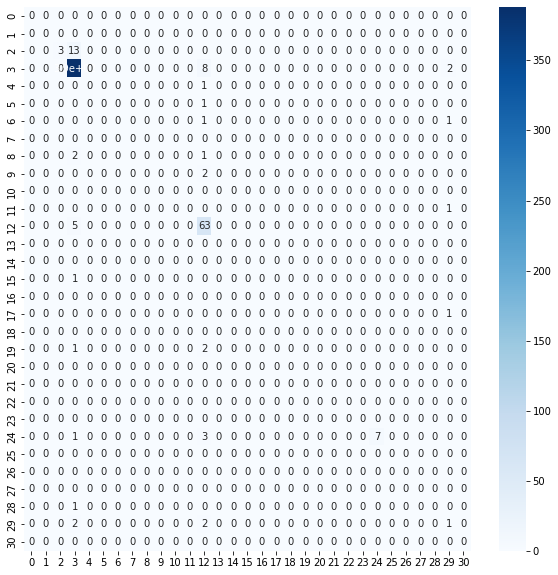

In [125]:
# predict classes from test dataset
test_set.reset()
Y_pred = model.predict(test_set, steps = test_set.n // test_set.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = len(test_set.class_indices)
class_values = list(test_set.class_indices.values())
class_labels = list(test_set.class_indices.keys())

print('Classification Report')
print(classification_report(test_set.classes, y_pred))

print('Confusion Matrix')
confusionmatrix = confusion_matrix(test_set.classes, y_pred, labels = class_values)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

In [126]:
# serialize weights to HDF5
model.save_weights('/content/drive/MyDrive/datasets/lila.bc/vit-model-weights-e20.h5')
print('Saved model to disk')

# !cp /content/drive/MyDrive/datasets/lila.bc/model.h5 -d /content/dataset
# model = vit_classifier.load_weights('/content/dataset/model.h5')
# print("Loaded model from disk")

Saved model to disk


## Predict Specific Image

In [127]:
# get specific image from test dataset
row = test_df.loc[test_df['label'] == 'gemsbokoryx']

image_to_test = row.image_path_rel.values[0]
label = row.label.values[0]

from keras.preprocessing import image
image_to_test = image.load_img(image_to_test,
                              target_size = (IMAGE_SIZE, IMAGE_SIZE))
image_to_test = image.img_to_array(image_to_test)
image_to_test /= 255
image_to_test = np.expand_dims(image_to_test, axis = 0)

In [128]:
# predict class from image
test_set.reset()
Y_pred = model.predict(image_to_test)
y_test_cat = keras.utils.to_categorical(Y_pred, NUM_CLASSES)

sorting = (-Y_pred).argsort()
sorted = sorting[0][:3]

for value in sorted:
  predicted_label = CLASSES[value]
  prob = (Y_pred[0][value]) * 100
  prob = "%.2f" % round(prob,2)
  print("I have %s%% sure that it belongs to %s." % (prob, predicted_label))

I have 331.06% sure that it belongs to gemsbokoryx.
I have 193.60% sure that it belongs to eland.
I have 191.49% sure that it belongs to steenbok.


In [37]:
Y_pred

array([[-0.07082997, -0.07157309, -0.00343575,  0.07413451, -0.06333484,
        -0.07155795, -0.07074429, -0.07040986, -0.0695862 , -0.07292248,
        -0.0707766 , -0.06738321,  0.07019276, -0.07019532, -0.07139429,
        -0.07235267, -0.07217757, -0.07133044, -0.07054402, -0.06787883,
        -0.07063252, -0.06970719, -0.07143719, -0.07192095, -0.06558289,
        -0.0714018 , -0.07098873, -0.07007844, -0.06840937, -0.06712842,
        -0.07005476]], dtype=float32)